## The architecture of Visual Cortex

Many neurons in the visual cortex have a small *local receptive field*, meaning they react only to visual simuli located in a limited region of the visual field (In the picture below, the local receptive fields of five neurons are represented by dashed circle)

![local_receptive_field](local_receptive_field.png)

## Convolutional Layers

The most important building block of a CNN is the *convolutional layer*: neurons on the first convolutional layer are not connected to every single pixel in the input image, but only to pixels in their receptive fields. In turn, each neuron in the second convolutional layer is connected only to neurons located within a small rectangle in the first layer.

![Convolutional_layers](Convolutional_layers.png)

A neuron located in row *i*, column *j* of a given layer is connected to the outputs of the neurons in the previous layer located in rows *i* --> *i + f_h - 1*, columns *j* --> *j + f_w - 1*, where *f_h* and *f_w* are the height and width of the receptive field. **(no strides)**

*Zero padding*: In order for a layer to have the same height and width as the previous layer, it is common to add zeros around the inputs.

![Layers_connnection_zero_padding](Layers_connection_zero_padding.png)

It's also possible to connect a large input layer to a much smaller layer by *spacing out the receptive fields* --> dramatically reduces the model's computational complexity. The shift from one receptive field to the next is called *the stride*.

A neuron located in row *i*, column *j* in the upper layer is connected to the outputs of the neurons in the previous layer located in row *i * s_h* --> *i * s_h + f_h - 1*, columns *j * s_w* --> *j * s_w + f_w - 1*, where *s_h* and *s_w* are the vertical and horizontal strides.

![Dimensionality_reduce_with_stride_2](Dimensionality_reduce_with_stride_2.png)

## Filters


A neuron's weights can be represented as a small image the size of the receptive field (the picture below shows two possible sets of weights, called *filters* (or *convolutional layers*))

![2_sets_of_filters](2_sets_of_filters.png)

A layer full of neurons using the same filter outputs a *feature map*, which highlights the areas in an image that activate the filter the most

## Stacking Multiple Feature Maps

In reality a convolutional layer has multiple filters (decide on your own) and outputs one feature map per filter, so it's more accurately represented in 3D 

![Conv_with_multi_feature_maps](Conv_layer_with_multi_feature_maps.png)

It has one neuron per pixel in each feature map, and all neurons within a given feature map share the same parameters. Neurons in different feature maps use different parameters

A neuron located in row *i*, column *j* of the feature map *k* in a given convolutional layer *l* is connected to the outputs of the neurons in the previous layer *l-1*, located in row *i * {s_h}* --> *i * {s_h} + {f_h} - 1* and columns *j * {s_w}* --> *j * {s_w} + {f_w} -1*, across all feature maps.

## Tensorflow Implementation

In TensorFlow,

- input image is typically represented as a 3D tensor of shape *[height,, width, channels]*.

- A mini-batch is represented as a 4D tensor of shape
*[mini_batch_size, height, width, channels]*

- The weights of a convolutional layer are represented as a 4D tensor of shape *[f_h, f_w, f_n_phẩy, f_n]*
    
    . *f_h, f_w* are the height and width of the receptive field, and *f_n_phẩy* is the number of feature maps in the previous layer (layer *l-1*)

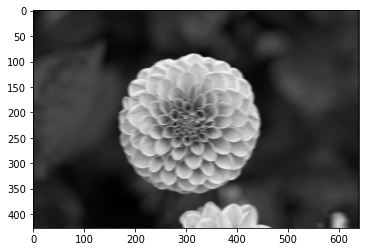

In [5]:
#Example of using filter
from sklearn.datasets import load_sample_image
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
china  = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

#Create 2 filters
filters = np.zeros(shape=(7,7,channels,2), dtype=np.float32)
filters[:, 3, :, 0] = 1 # vertical line
filters[3, :, :, 1] = 1 # horizontal line


outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.imshow(outputs[1,:,:,1], cmap="gray")
plt.show()

**Notes**: Some explanation for tf.nn.conv2d():

- *images* is the input mini_batch (4D tensor)

- *filters* is the set of filters to apply (4D tensor)

- *strides* could also be a 1D array with four elements, where the two central elements are the vertical and horizontal strides (*s_h and s_w*). The first and the last elements can be used to specify a batch stride (to skip some instances) and a channel stride (to skip some of the previous layer's feature map or channels). For example, stride = 1 <=> stride = [1, s_h=1, s_w=1, 1]

- *padding* must be either "same" or "valid":

    + If set to "same", the convolutional layer uses zero padding. THe output size is set to the number of input neurons devided by the stride, rounded up. For example, if the input size is 13 and the stride is 5 then the output size is 3 (13 / 5 = math.round(2.6) = 3)

    + if set to "valid", the convolutional layer does *not use* zero padding and may ignore some rows and columns at the bottom and right of the input image, depending on the stride

    ![padding](padding.png)

In [1]:
import keras
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=2, padding='same', activation='relu')

"""
This code creates a Conv2D layer with a few hyperparameters:
    + The number of filters
    + Height and width of receptive field
    + The strides
    + Padding type 
"""

'\nThis code creates a Conv2D layer with a few hyperparameters:\n    + The number of filters\n    + Height and width of receptive field\n    + The strides\n    + Padding type \n'

## Memory Requirements

The problem with CNNs is that the convolutional layers require a huge amount of RAM --> true during training, because the reverse pass of backpropagation requires all the intermediate values computed during the forward pass.

- During inference (i.e., when making a prediction for a new instance) the RAM occupied by one layer can be release as soon as the next layer has been computed --> only need as much RAM as required by two consecutive layers.

- During training everything computed during the forward pass needs to be preseverd for the reverse pass, so the amount of RAM needed is the the total amount of RAM required by all layers.

- How to avoid RAM from out-of-memory?

    + Try reducing the mini-batch size
    + Try reducing dimensionality using a stride, or removing a few layers


## Pooling layers

- The pooling layers goal is to *subsample (i.e, shrink)* the input image in order to reduce the computational load, the memory usage, and the number of parameters (limiting the risk of overfitting).

-  Each neuron in a pooling layer is connected to the outputs of a limited number of neurons in the previous layer, located within a small rectangular receptive field

- A pooling neuron has no weigths; all it does is aggregate the inputs using an aggregation function such as the max or mean.


- Other than reducing computations, memory usage, and the number of parameters, a max pooling layer also introduces some level of *invariance* to small translations


 ![Invariance_to_small_translations](Invariance_to_small_translations.png)


- *Translation invariance* means when you shift by one pixels of the image (image A to B) to the right the outputs of the max pooling layer for images A and B are identical


- The output of the max pooling layer for image C is different: it is shifted one pixel to the right (but there is still 75% invariance)


- If the input image is translated by one pixel to the right, the output should also be translated by one pixel to the right. The goal in this case is *equivariance*, not invariance: a small change to the inputs should lead to a corresponding small change in the output

- An *average pooling layer* computes the mean rather than the max. 

- *Global average pooling layer* computes the mean of each entire feature map --> means that it just outputs a single number per feature and per instance

## CNN Architectures

In [10]:
import numpy as np

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]

In [11]:
model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=[28, 28, 1]),
    keras.layers.Conv2D(filters=64, kernel_size=7, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.Conv2D(filters=256, kernel_size=3, padding='same', activation='relu'),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(10, activation='softmax')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_21 (Conv2D)           (None, 28, 28, 64)        3200      
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 128)       73856     
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 14, 14, 128)       147584    
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 7, 7, 256)         295168    
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 7, 7, 256)        

In [12]:
optimizer = keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_valid, y_valid))


Epoch 1/15
1719/1719 [==============================] - 20s 8ms/step - loss: 1.1256 - accuracy: 0.5928 - val_loss: 0.3952 - val_accuracy: 0.8560
Epoch 2/15
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4864 - accuracy: 0.8343 - val_loss: 0.3736 - val_accuracy: 0.8752
Epoch 3/15
1719/1719 [==============================] - 13s 8ms/step - loss: 0.4035 - accuracy: 0.8633 - val_loss: 0.3094 - val_accuracy: 0.8832
Epoch 4/15
1719/1719 [==============================] - 14s 8ms/step - loss: 0.3571 - accuracy: 0.8792 - val_loss: 0.3172 - val_accuracy: 0.8878
Epoch 5/15


KeyboardInterrupt: 